# Training:

In [4]:
import nets
import volumes
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
nets.K.set_image_data_format('channels_last')

In [7]:
#========================================================================
# Set density file, truth table, filepaths
#========================================================================
BOX = 1000. # Mpc
GRID = 512
SUBGRID = 128
# Density field:
FILE_DEN = 'X_Img_train.npy'
# Distance tranform array:
FILE_MASK = 'Y_Img_train.npy'
print('>>> Loading Data')
X_Img_train = np.load(FILE_DEN)  # read density images
Y_Img_train = np.load(FILE_MASK) # read distance transform images
print('X_Img_train shape: ', X_Img_train.shape)
print('Y_Img_train shape: ', Y_Img_train.shape)
# shape should be (batches,rows,cols,channels)

>>> Loading Data
X_Img_train shape:  (256, 128, 128, 1)
Y_Img_train shape:  (256, 128, 128, 1)


In [8]:
# split into training and test sets:
X_train, X_test, Y_train, Y_test = train_test_split(X_Img_train, Y_Img_train,
                                                    test_size=0.2, random_state=42)
print('Split into training and test sets...')
print(f'Now the shapes are:')
print(f'X_train: {X_train.shape}')
print(f'Y_train: {Y_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'Y_test: {Y_test.shape}')


Split into training and test sets...
Now the shapes are:
X_train: (204, 128, 128, 1)
Y_train: (204, 128, 128, 1)
X_test: (52, 128, 128, 1)
Y_test: (52, 128, 128, 1)


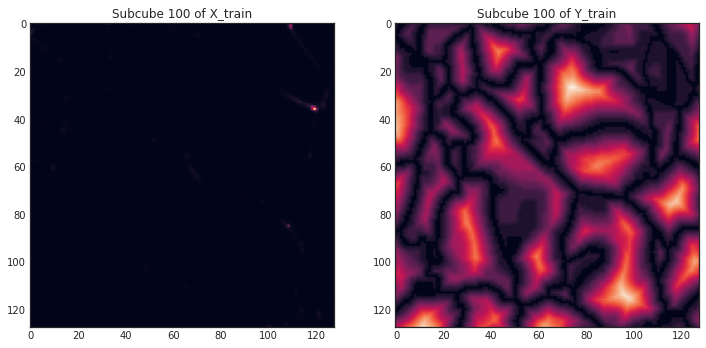

In [10]:
#========================================================================
# Inspect subcubes
#========================================================================
fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].set_title('Subcube 100 of X_train')
axs[1].set_title('Subcube 100 of Y_train')
axs[0].imshow(X_train[101,:,:,0]) # take np.log10 to see more detail
axs[1].imshow(Y_train[101,:,:,0])
#plt.savefig('2DTest-sc-comp.jpg')

In [ ]:
MODEL_NAME = '2DTest.h5'
batch_size = 64
epochs = 1000
patience = 100
input_layer = nets.Input((128, 128, 1))
output_layer = nets.build_model(input_layer, 64)
model = nets.Model(input_layer,output_layer,name=MODEL_NAME)

model.compile(optimizer='adam',loss='mean_squared_error',metrics=['mean_squared_error','mean_absolute_error'])
model.summary()

model_chkpt = nets.ModelCheckpoint(MODEL_NAME, monitor='val_loss',
                              save_best_only=True,verbose=1)
early_stop = nets.EarlyStopping(patience=patience,restore_best_weights=True)
history = model.fit(X_train, Y_train,batch_size=batch_size, epochs = epochs,
                    verbose = 2, shuffle=True,validation_data=(X_test, Y_test),
                    callbacks=[model_chkpt,early_stop])
model.save(MODEL_NAME)


In [ ]:
#========================================================================
# Plot training loss, accuracy:
#========================================================================
def plot_training(history,savefig=False):
  #mape = history.history['MeanAbsolutePercentageError']
  mse = history.history['mean_squared_error']
  mae = history.history['mean_absolute_error']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  fig,axs = plt.subplots(2,1,figsize=(5,9))

  #axs[0].plot(epochs,mape)
  #axs[0].plot(epochs,mse)
  axs[0].plot(epochs,mae)
  axs[0].set_xlabel('Epochs')
  axs[0].set_ylabel('Mean Absolute Error')
  axs[0].set_title('Training Metrics')

  axs[1].plot(epochs,loss,label='Loss')
  axs[1].plot(epochs,val_loss,label='Validation Loss')
  axs[1].legend(loc='upper right')
  axs[1].set_xlabel('Epochs')
  axs[1].set_ylabel('Loss (Mean Squared Error)')
  axs[1].set_title('Training Loss')
  
  if savefig == True:
    plt.savefig(MODEL_NAME.split('.')[0]+'-accloss_vs_epochs.jpg')

plot_training(history,savefig=True)

# Prediction
Run predict on data it was trained on

In [ ]:
PRED_NAME = MODEL_NAME.split('.')[0] + '-pred.fvol'
Y_Img_pred = model.predict(X_train,batch_size=16,verbose=2)

In [ ]:
#========================================================================
# Compare density field, distance transform, and predicted distance transform
#========================================================================
i = 63
idx = 63
fig,axs = plt.subplots(1,3,figsize=(36,12))
fig.suptitle(f'2-Dimensional Test of Density ==> Dist Transform, Model {MODEL_NAME}, Subcube {i}, Slice {idx}', fontsize=18)
axs[0].set_title('Log Density'); axs[1].set_title('Analytical Distance Transform');
axs[2].set_title('Distance Transform PREDICTION');
im0 = axs[0].imshow(np.log10(X_test[i,:,:,0]),interpolation=None,origin='lower')
im1 = axs[1].imshow(Y_test[i,:,:,0],interpolation=None,origin='lower')
im2 = axs[2].imshow(Y_Img_pred[i,:,:,0] ,interpolation=None,origin='lower')
cb0 = plt.colorbar(im0,ax=axs[0],fraction=0.046, pad=0.04)
cb1 = plt.colorbar(im1,ax=axs[1],fraction=0.046, pad=0.04)
cb2 = plt.colorbar(im2,ax=axs[2],fraction=0.046, pad=0.04)
plt.savefig(PRED_NAME.split('.')[0]+'-comp') # save slice comparison
print('Saved comparison figure of model '+MODEL_NAME+' at '+PRED_NAME.split('.')[0]+'-comp.png')